<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#User-Guide-on-nonlinear-example" data-toc-modified-id="User-Guide-on-nonlinear-example-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>User Guide on nonlinear example</a></span><ul class="toc-item"><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data Preparation</a></span></li><li><span><a href="#DFS-with-fixed-hyper-parameters" data-toc-modified-id="DFS-with-fixed-hyper-parameters-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>DFS with fixed hyper-parameters</a></span></li><li><span><a href="#Selection-of-$s$" data-toc-modified-id="Selection-of-$s$-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Selection of $s$</a></span></li></ul></li></ul></div>

# Deep Feature Selection
In this notebook, we will demonstrate how to implement our method on the nonlinear simulation examples from our paper.
## User Guide on nonlinear example
In this example, a high dimensional dataset with 500 covariates and 300 observations is generated using the following equation

\begin{equation}
    y=\begin{cases}
        1, & e^{x_1} + x_2^2 + 5\sin(x_3 x_4) - 3 > 0\\
        0, & \text{otherwise,}
    \end{cases}
\end{equation}

i.e. among 500 covariates, only the first 4 variables actually contributed to the response. Our task is to correctly select the important variables. Please see section 5.2 of the paper for detailed generation process.

In [14]:
import sys
import matplotlib.pyplot as plt
sys.path.append("../../src")
#from time import clock
import numpy as np
import math
import pandas as pd
#import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import grad
from torch.nn.parameter import Parameter
from utils import data_load_n, data_load_l, measure, accuracy
from models import Net_nonlinear, Net_linear
from dfs import DFS_epoch, training_n

### Data Preparation
We will load our data in the following chunk. The data, both covariates and response, need to be load as `pytorch` `Tensor` objects to be fed into the DFS algorithm. The function `data_load_n` will read in dataset and split it into training and test set so that both sets have same number of positive and negative samples.

In [26]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def initialize_parameters(input_size, hidden_size, output_size):
    np.random.seed(42)
    W1 = np.random.normal(loc=0, scale=1, size=(input_size, hidden_size))
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.normal(loc=0, scale=1, size=(hidden_size, output_size))
    b2 = np.zeros((1, output_size))
    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

def forward_propagation(X, parameters):
    Z1 = np.dot(X, parameters['W1']) + parameters['b1']
    A1 = relu(Z1)
    Z2 = np.dot(A1, parameters['W2']) + parameters['b2']
    A2 = sigmoid(Z2)
    return {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}

def predict(X, parameters):
    forward = forward_propagation(X, parameters)
    return (forward['A2'] > 0.5).astype(int)

# Set up neural network parameters
input_size = 100
hidden_size = 264
output_size = 1

# Generate random input data
np.random.seed(42)
n_samples = 1000

# Generate the first 33 variables using the neural network
X_first_33 = np.random.normal(loc=0, scale=1, size=(n_samples, 33))
parameters = initialize_parameters(33, hidden_size, output_size)
forward = forward_propagation(X_first_33, parameters)
y_neural_network = forward['A2']

# Generate random values for the remaining variables
X_rest = np.random.normal(loc=0, scale=1, size=(n_samples, input_size - 33))

# Combine the generated values
X = np.concatenate((X_first_33, X_rest), axis=1)

# Threshold for binary classification
threshold = 0.5
y_binary_neural_network = (y_neural_network > threshold).astype(int)

# Add the generated y values to the existing DataFrame
data = pd.DataFrame(X, columns=[f'var{i}' for i in range(input_size)])
data['y'] = y_binary_neural_network

# Print the DataFrame
print(data.head())

       var0      var1      var2      var3      var4      var5      var6  \
0  0.496714 -0.138264  0.647689  1.523030 -0.234153 -0.234137  1.579213   
1 -1.057711  0.822545 -1.220844  0.208864 -1.959670 -1.328186  0.196861   
2 -0.072010  1.003533  0.361636 -0.645120  0.361396  1.538037 -0.035826   
3 -0.234587 -1.415371 -0.420645 -0.342715 -0.802277 -0.161286  0.404051   
4 -1.062304  0.473592 -0.919424  1.549934 -0.783253 -0.322062  0.813517   

       var7      var8      var9  ...     var91     var92     var93     var94  \
0  0.767435 -0.469474  0.542560  ... -0.029352  0.395307  0.033023  1.346941   
1  0.738467  0.171368 -0.115648  ...  1.021963  0.733179  1.378143 -0.990623   
2  1.564644 -2.619745  0.821903  ...  0.272634  0.342226 -1.098679  0.044570   
3  1.886186  0.174578  0.257550  ... -1.312467  0.536389 -1.671147 -0.838362   
4 -1.230864  0.227460  1.307143  ...  0.534347 -1.768415  0.995168  0.937367   

      var95     var96     var97     var98     var99  y  
0  0.774023

In [27]:
from sklearn.model_selection import train_test_split
X = data.iloc[:,:-1]
X = (X - X.mean()) / X.std()
Y = data.iloc[:,-1]
X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Application data

In [50]:
from sklearn.preprocessing import MinMaxScaler
df = pd.read_excel('cancer.xlsx')
data = df.rename(columns={'Column1': 'ID', 'Column2': 'Y', 'Column3': 'radius1', 'Column4': 'texture1', 'Column5': 'perimeter1', 
                     'Column6': 'area1', 'Column7': 'smoothness1', 'Column8': 'compactness1', 'Column9': 'concavity1', 'Column10': 'concave_points1',
                     'Column11': 'symmetry1', 'Column12': 'fractal_dimension1', 'Column13': 'radius2', 'Column14': 'texture2', 'Column15': 'perimeter2', 
                     'Column16': 'area2', 'Column17': 'smoothness2', 'Column18': 'compactness2', 'Column19': 'concavity2', 'Column20': 'concave_points2',
                     'Column21': 'symmetry2', 'Column22': 'fractal_dimension2', 'Column23': 'radius3', 'Column24': 'texture3', 'Column25': 'perimeter3', 
                     'Column26': 'area3', 'Column27':'smoothness3', 'Column28': 'compactness3', 'Column29': 'concavity3', 'Column30': 'concave_points3',
                     'Column31': 'symmetry3', 'Column32': 'fractal_dimension3'})
data['Y'] = data['Y'].replace({'B': 0, 'M': 1})
# features_to_normalize = ['var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8', 'var9', 'var0']
cols_to_normalize = data.columns[2:]

# Normalize the selected columns using Min-Max scaling
# scaler = MinMaxScaler()
# data[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])
data

,ID,Y,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [51]:
from sklearn.model_selection import train_test_split
X = data.drop(columns=['Y'])
X = (X - X.mean()) / X.std()
Y = data.iloc[:,-1]
X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### DFS with fixed hyper-parameters
In this section, we demonstrate how to run DFS with one given set of hyper-parameters. The hyper-parameters includes:
* `s`, the number of variables to be selected;
* `c`, the tunning parameters to control the magnitude of $\lambda_1$ and $\lambda_2$;
* `epochs`, the number of DFS iterations to be run;
* `n_hidden1` & `n_hidden2`, the number of neurons in the fully connect neural networks;
* `learning_rate`, the learning rate for optimizer;
* `Ts` & `step`, the parameters to control the optimization on given support

Among the above hyper-parameters, `s` is the most important parameters, and the selection of $s$ will be demonstrated in next sections. `c` can be selection through a sequence of candidates that returns the smallest loss function. Others mostly are meant to help the convergence of the optimization steps.

In [52]:
# specify hyper-paramters
import torch
N, p = X.shape
s = 2
c = 1
epochs = 10
n_hidden1 = 50
n_hidden2 = 10
learning_rate = 0.05
Ts = 25 # To avoid long time waiting, this parameter has been shorten
step = 5
X = torch.tensor(X.values, dtype=torch.float32)
Y = torch.tensor(Y.values, dtype=torch.long)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
Y_test = torch.tensor(Y_test.values, dtype=torch.long)
# Define Model
torch.manual_seed(1) # set seed
# Define a model with pre-specified structure and hyper parameters
model = Net_nonlinear(n_feature=p, n_hidden1=n_hidden1, n_hidden2=n_hidden2, n_output=2)
# Define another model to save the current best model based on loss function value
# The purpose is to prevent divergence of the training due to large learning rate or other reason
best_model = Net_nonlinear(n_feature=p, n_hidden1=n_hidden1, n_hidden2=n_hidden2, n_output=2)


# Define optimizers for the optimization with given support
# optimizer to separately optimize the hidden layers and selection layers
# the selection layer will be optimized on given support only.
# the optimzation of hidden layers and selection layer will take turn in iterations
optimizer = torch.optim.Adam(list(model.parameters()), lr=learning_rate, weight_decay=0.0025*c)
optimizer0 = torch.optim.Adam(model.hidden0.parameters(), lr=learning_rate, weight_decay=0.0005*c)


# Define loss function
lf = torch.nn.CrossEntropyLoss()


# Allocated some objects to keep track of changes over iterations
hist = []
SUPP = []
LOSSES = []
supp_x = list(range(p)) # initial support
SUPP.append(supp_x)


### DFS algorithm

for i in range(epochs):
    # One DFS epoch
    
    model, supp_x, LOSS = DFS_epoch(model, s, supp_x, X, Y, lf, optimizer0, optimizer, Ts, step)
    LOSSES = LOSSES + LOSS
    supp_x.sort()
    # Save current loss function value and support
    hist.append(lf(model(X), Y).data.numpy().tolist())
    SUPP.append(supp_x)
    # Prevent divergence of optimization over support, save the current best model
    if hist[-1] == min(hist):
        best_model.load_state_dict(model.state_dict())
        best_supp = supp_x
    # Early stop criteria
    if len(SUPP[-1]) == len(SUPP[-2]) and (SUPP[-1] == SUPP[-2]).all():
        break

print("Training finished in" , len(SUPP)-1, "epochs")

Training finished in 2 epochs


In the following chunk, we will demonstrate the results from the DFS algorithm, in terms of selected support, training error and test error for __one step__ procedure.

In [53]:
### Metric calculation

err_train_1 = 1-accuracy(best_model, X, Y)
err_test_1 = 1-accuracy(best_model, X_test, Y_test)
print("The support selected is:", best_supp)
print("The index of non-zero coefficents on selection layer:", 
      np.where(best_model.hidden0.weight != 0)[0])
print("The training error is:", err_train_1)
print("The test error is:", err_test_1)

The support selected is: [ 3 23]
The index of non-zero coefficents on selection layer: [ 3 23]
The training error is: 0.0
The test error is: 0.0


From the results above, we have successfully selected the right support, i.e. the first 4 variables. (Note in `python` starting index is 0)

In the following chunk, we will perform a two-step procedure to train the `best_model` on the given support.

Two-step procedure is used for two reasons, to get better predictive performance and to get better estimation of $bic$ which is important in selection of optimal $s$.

As we demonstrated on the above chunk, the selection layer of `best_model` has non-zero coefficients on given support. In the second step, we treat `best_model` as our initial model and update parameters only in hidden layer.

In [46]:
# Define optimizer only update parameters in hidden layer.
_optimizer = torch.optim.Adam(list(best_model.parameters())[1:], lr=0.01, weight_decay=0.0025)
# Training
for _ in range(100):
    out = best_model(X)
    loss = lf(out, Y)
    _optimizer.zero_grad()
    loss.backward()
    _optimizer.step()

### metric calculation
acc_train = accuracy(best_model, X, Y)
acc_test = accuracy(best_model, X_test, Y_test)
print("The training accuracy of two step is: ", acc_train*100, "%", sep="")
print("The test accuracy of two step is: ", acc_test*100, "%", sep="")

The training accuracy of two step is: 100.0%
The test accuracy of two step is: 100.0%


The result has shown that the predictive performance of our model is increased. 

All good results shown above is based on the correct given $s$. However, in reality, $s$ is unknown for most of the time. So the next thing would be finding the optimal $s$

### Selection of $s$
In this section, we demonstrate the procedure of selection of optimal $s$. We have wrapped up the training procedure above in a function `training_n`. For each given $s$, $bic$, defined as $-2 \cdot \log \hat{L} + s \cdot \log n$, of the model will be automatically calculated by `training_n`, also the trained model with the given $s$ will also be returned.

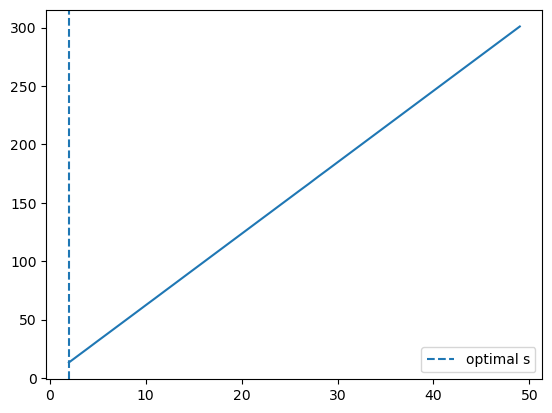

In [47]:
Ss = list(range(2, 50)) # We shorten the candidates list in the notebooks
BIC = [] # Store the bic for different s
best_model = Net_nonlinear(n_feature=p, n_hidden1=n_hidden1, n_hidden2=n_hidden2, n_output=2)
for i, s in enumerate(Ss):
    # Training dataset k with given s
    model, supp, bic, _, [err_train, err_test] = training_n(X, Y, X_test, Y_test, c, s, 
                                                            epochs=10, Ts=25)
    # Store bic values
    BIC.append(bic)
    # if current bic is the smallest, save the trained model, support and other metric
    if bic == min(BIC):
        best_model.load_state_dict(model.state_dict())
        best_supp = supp
        best_err_train, best_err_test = err_train, err_test # one step model training and testing error

idx = np.argmin(BIC)
best_s = Ss[idx]
plt.plot(Ss, BIC)
plt.axvline(x=best_s, ls='--', label="optimal s")
plt.legend()
plt.show()

From the graph above, we can tell $s=4$ is the optimal $s$, and the corresponding model is stored in `best_model` which is the same model showed in section 1.2

In [48]:
best_s

2